# Lab 3 Control Óptimo

### Integrantes: Víctor Saez, Miguel Escobar

### Ejercicio 1

In [1]:
import numpy as np
import control as ctr
# Escribo las matrices A y B del sistema:

A = np.array([[0, 1, 0, 0, 0],
              [1, 0, 0, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 1, 0, 0],
              [1, 0, 1, 0, 0]])

B = np.array([[0, 0],
              [1, 0],
              [0, 0],
              [0, 1],
              [0, 0]])

# Determino la Matriz de Kalman para estudiar controlabilidad:

Kalman = ctr.ctrb(A, B)

print("Rango de la matriz de Kalman:", np.linalg.matrix_rank(Kalman))

if np.linalg.matrix_rank(Kalman) == np.shape(A)[0]:
    print("El sistema es controlable")

Rango de la matriz de Kalman: 5
El sistema es controlable


Para estudiar la existencia de un control de tiempo mínimo, bastaría ver la existencia de un control que lleve el sistema al origen. Este existe, ya que la condicion inicial para $(x, y)$ está dentro de la caja $[-5, 5] \times [-5, 5]$,  por lo que podemos controlar la aceleración (y por ende la posición, considerando que la partícula parte del reposo) en $(x, y)$ de la partícula. Esto nos permite controlar la posición en $z$, ya que indirectamente controlamos su velocidad mediante un control de $x$ e $y$. Así, podemos llevar la partícula al origen, y por ende existe un control de tiempo mínimo.

Un ejemplo más concreto en este caso, sería escoger un control inicial tal que $x$ e $y$ lleguen a 0, luego, un control que los lleve a $(-\epsilon, -\epsilon)$, con $\epsilon$ suficientemente pequeño. Esto hace que $z$ baje lentamente, tan lento como quisieramos. Luego, cuando $z$ esté lo suficientemente cerca del origen, podemos escoger un control que lleve a $(x, y)$ a $(0, 0)$ tal que coincida con llevar a $z$ a 0. Esto nos permite llevar a la partícula al origen. Como existe una solución factible, entonces existe una solución minimal.

### Ejercicio 2

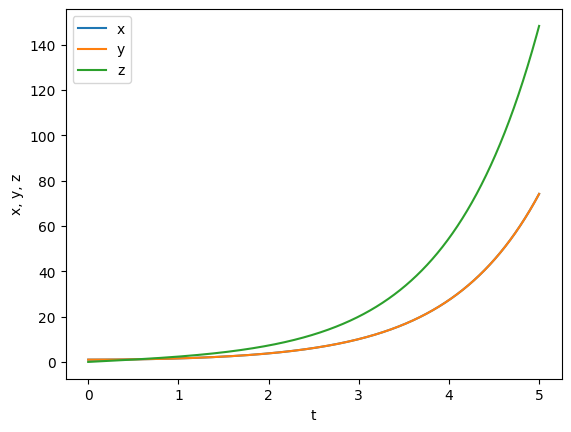

In [2]:
# Método de Euler a paso fijo:

def rhs(r, control, t):
    result = A @ r + B @ control
    assert result.shape == r.shape
    return result

def paso_euler(r, control, h, t):
    return r + h * rhs(r, control, t)

def solucion_euler(r0, control_array, h, N):
    times = np.arange(N + 1) * h
    solution = np.zeros((N + 1, 5))
    solution[0] = r0
    for i in range(N):
        solution[i + 1] = paso_euler(solution[i], control_array[i], h, times[i])
    return times, solution


import matplotlib.pyplot as plt

r0 = np.array([1, 0, 1, 0, 0])

tf = 5
N = 10000
h = tf / N

zero_control = np.zeros((N, 2))
times, solution = solucion_euler(r0, zero_control, h, N)
plt.clf()
plt.plot(times, solution[:, 0], label="x")
plt.plot(times, solution[:, 2], label="y")
plt.plot(times, solution[:, 4], label="z")
plt.legend()
plt.xlabel("t")
plt.ylabel("x, y, z")
plt.show()

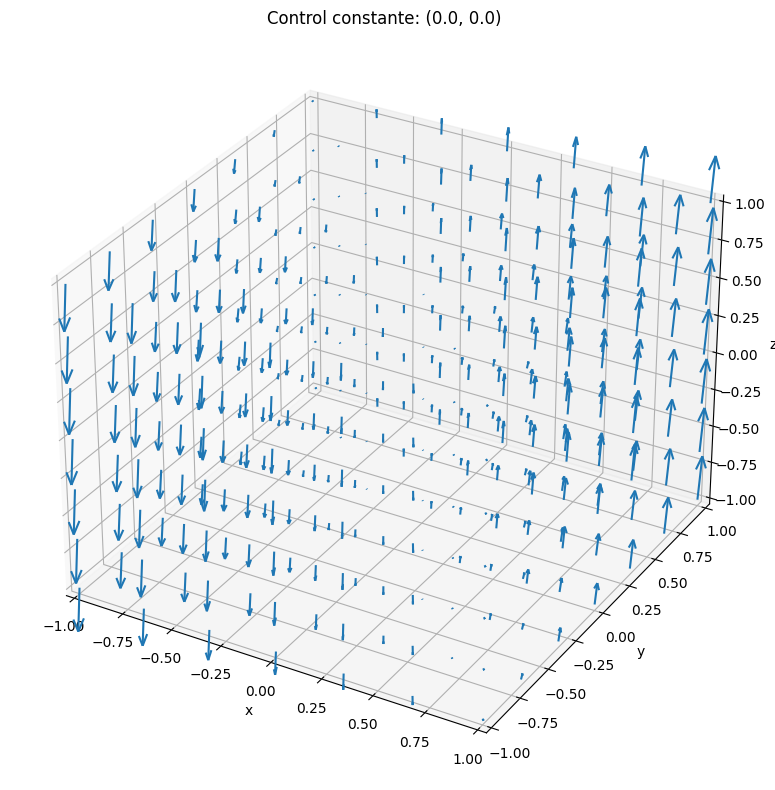

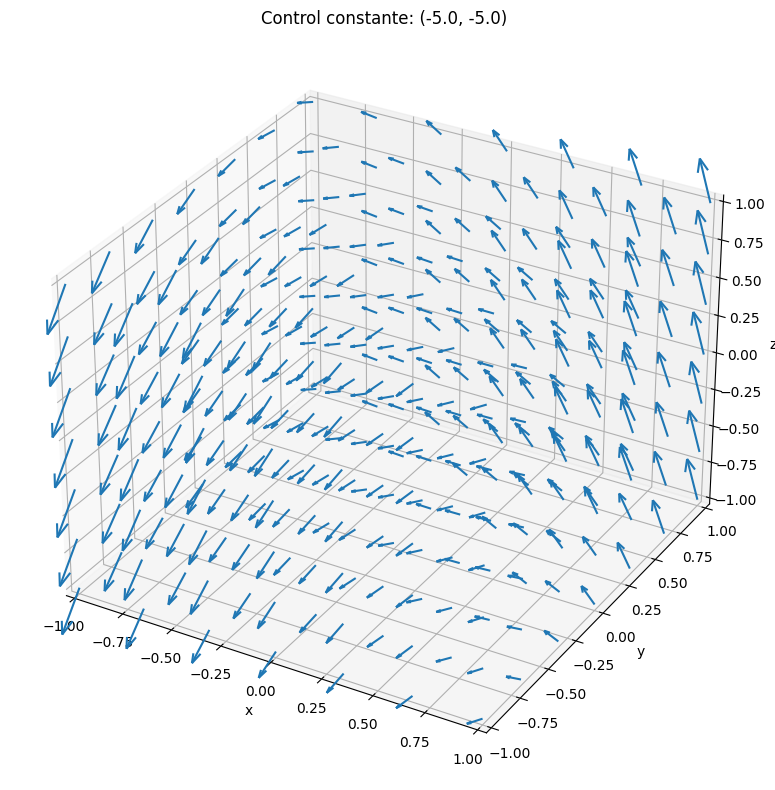

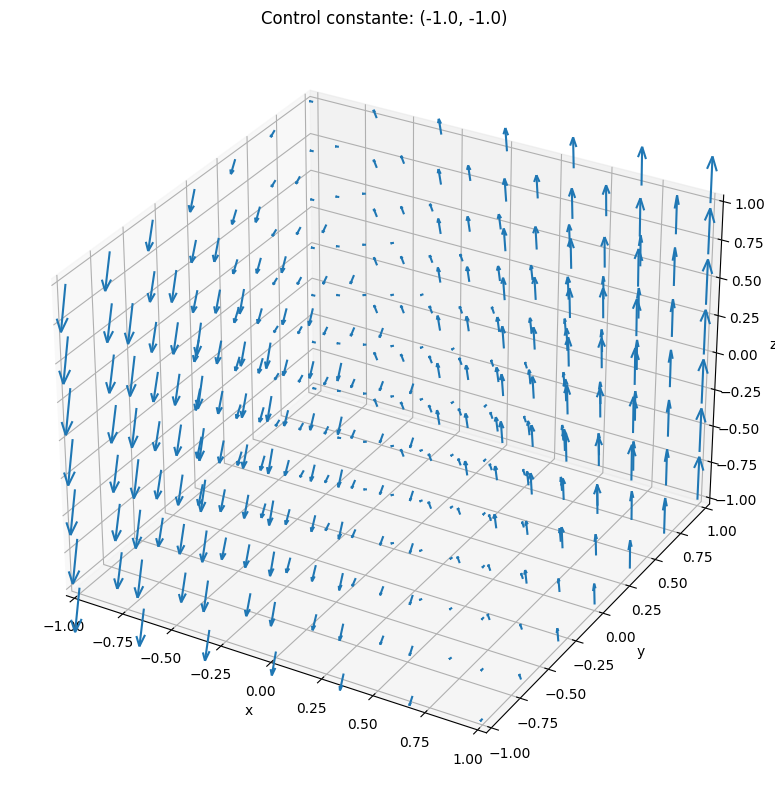

(<Figure size 800x800 with 1 Axes>,
 <Axes3D: title={'center': 'Control constante: (-1.0, -1.0)'}, xlabel='x', ylabel='y', zlabel='z'>)

In [3]:
def plot_quiver(A, B, control_array, npoints=7, show=True):

    x = np.linspace(-1, 1, npoints)
    y = np.linspace(-1, 1, npoints)
    z = np.linspace(-1, 1, npoints)

    X, Y, Z = np.meshgrid(x, y, z)
    U = np.zeros((npoints, npoints, npoints))
    V = np.zeros((npoints, npoints, npoints))
    W = np.zeros((npoints, npoints, npoints))

    for i in range(npoints):
        for j in range(npoints):
            for k in range(npoints):
                r = np.array([X[i, j, k], 0, Y[i, j, k], 0, Z[i, j, k]])
                U[i, j, k],_, V[i, j, k],_, W[i, j, k] = solucion_euler(r, control_array, 0.015, 10)[1][-1] - r
                                                        

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.quiver(X, Y, Z, U, V, W, length=1.)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.set_title("Control constante: ({}, {})".format(*control_array[0]))
    fig.tight_layout()
    if show:
        plt.show()
    return fig, ax

plot_quiver(A, B, zero_control)
plot_quiver(A, B, np.ones((N, 2))*(-5))
plot_quiver(A, B, np.ones((N, 2))*(-1))

### Ejercicio 4

C:\Users\Miguel\AppData\Local\Temp\ipykernel_14056\903792318.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


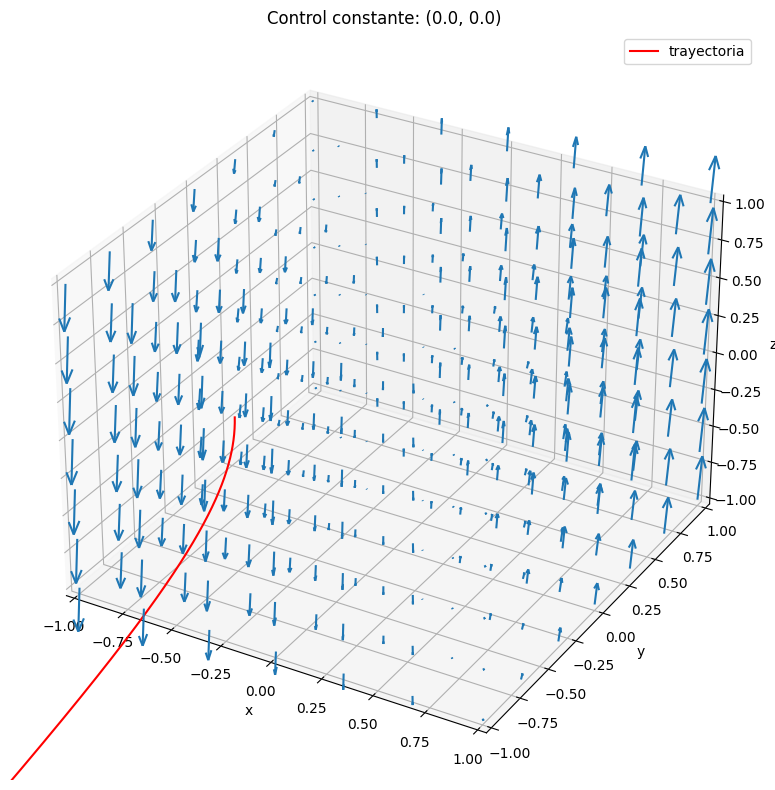

In [4]:
fig, ax = plot_quiver(A, B, zero_control, show=False)

r0 = np.array([-.5, 0, -0.5, 0, 0])
h = 1e-4
N = 30_000

solution = solucion_euler(r0, np.zeros((N, 2)), h, N)[1]

ax.plot(solution[:, 0], solution[:, 2], solution[:, 4], label="trayectoria", color="red")
ax.legend()
fig.show()

### Ejercicio 5

In [5]:
def obj_function(flattened_control_array, r0, h, N):
    control_array = flattened_control_array.reshape((N, 2))
    solution = solucion_euler(r0, control_array, h, N)[1]
    final_position = np.array([solution[-1][0], solution[-1][2], solution[-1][4]]) 
    return np.linalg.norm(final_position)**2

from scipy.optimize import minimize

r0 = np.array([1, 0, 1, 0, 0])
h = 1e-2
N = 350

bounds = [(-5, 5) for _ in range(2*N)]
result = minimize(obj_function, -4*np.ones((2*N)), args=(r0, h, N), bounds=bounds, method='L-BFGS-B', options={'disp': True})

if result.success:
    print("Control que lleva a 0 encontrado\n")
    control = result.x.reshape((N, 2))
    fig = plt.figure(figsize=(8, 8))
    fig.clf()
    ax = fig.add_subplot(121)
    ax.plot(control[:, 0], label="Control en x")
    ax.plot(control[:, 1], label="Control en y")
    ax.legend()
    ax.set_title("Control obtenido")

    ax2 = fig.add_subplot(122)
    times, solution = solucion_euler(r0, control, h, N)
    ax2.plot(times, solution[:, 0], label="x")
    ax2.plot(times, solution[:, 2], label="y")
    ax2.plot(times, solution[:, 4], label="z")
    ax2.legend()
    ax2.set_title("Trayectoria obtenida")
    fig.show()

else:
    print("No se encontró control que lleve a 0")



No se encontró control que lleve a 0


### Otra forma del Ejercicio 5

Control que lleva a 0 encontrado

 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 1.6079884167468204
       x: [-4.602e+00 -5.000e+00 ... -1.000e+00  6.251e-03]
     nit: 32
     jac: [ 6.006e-03  7.059e-03 ...  0.000e+00 -1.332e+00]
    nfev: 205422


C:\Users\Miguel\AppData\Local\Temp\ipykernel_14056\1719154893.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


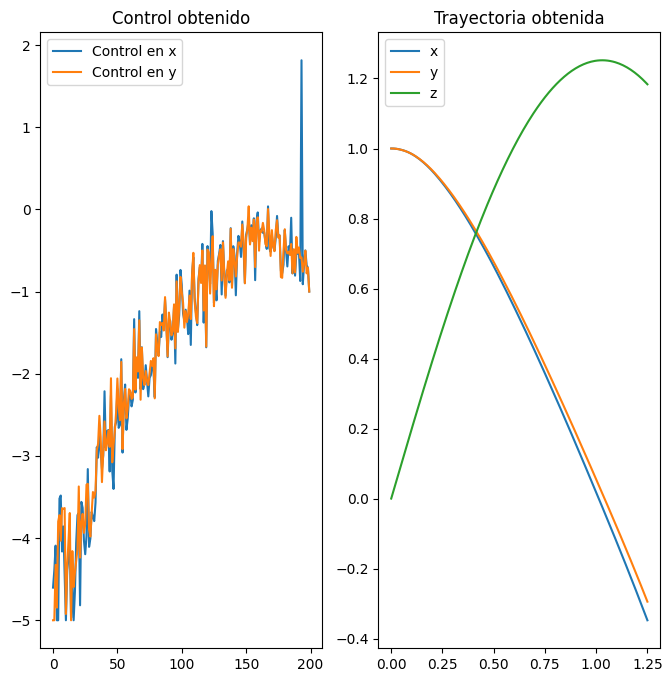

In [6]:
def obj_function(params, r0, N):
    h = params[-1]
    flattened_control_array = params[:-1]
    control_array = flattened_control_array.reshape((N, 2))
    solution = solucion_euler(r0, control_array, h, N)[1]
    final_position = np.array([solution[-1][0], solution[-1][2], solution[-1][4]]) 
    result = np.linalg.norm(final_position)**2
    return result

from scipy.optimize import minimize

r0 = np.array([1, 0, 1, 0, 0])
N = 200

bounds = [(-5, 5) for _ in range(2*N)]
bounds.append((1e-4, 1e-1))
initial_guess = np.concatenate((-1*np.ones((2*N)), [1e-2]))
result = minimize(obj_function, initial_guess, args=(r0, N), bounds=bounds, method='TNC', options={'disp': True})

if result.success:
    print("Control que lleva a 0 encontrado\n")
    print(result)
    control_result = result.x[:-1]
    h = result.x[-1]
    control = control_result.reshape((N, 2))
    fig = plt.figure(figsize=(8, 8))
    fig.clf()
    ax = fig.add_subplot(121)
    ax.plot(control[:, 0], label="Control en x")
    ax.plot(control[:, 1], label="Control en y")
    ax.legend()
    ax.set_title("Control obtenido")

    ax2 = fig.add_subplot(122)
    times, solution = solucion_euler(r0, control, h, N)
    ax2.plot(times, solution[:, 0], label="x")
    ax2.plot(times, solution[:, 2], label="y")
    ax2.plot(times, solution[:, 4], label="z")
    ax2.legend()
    ax2.set_title("Trayectoria obtenida")
    fig.show()

else:
    print("No se encontró control que lleve a 0")

### Ejercicio 6
